#Belajar Pengembangan Machine Learning<br>
#Proyek Akhir : Image Classification Model Deployment<br>
Nama  : Yagy Christoper Sumule<br>
Email : yagybatman@gmail.com<br>
Sumber data : https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

Kriteria :
* Dataset yang akan dipakai bebas, namun minimal memiliki 1000 buah gambar.
* Dataset tidak pernah digunakan pada submission kelas machine learning sebelumnya.
* Dataset dibagi menjadi 80% train set dan 20% test set.
* Model harus menggunakan model sequential.
* Model harus menggunakan Conv2D Maxpooling Layer.
* Akurasi pada training dan validation set minimal sebesar 80%.
* Menggunakan Callback.
* Membuat plot terhadap akurasi dan loss model.
* Menulis kode untuk menyimpan model ke dalam format TF-Lite.

Anda dapat menerapkan beberapa saran untuk mendapatkan nilai tinggi, berikut sarannya:
* Dataset yang digunakan berisi lebih dari 2000 gambar.
* Mengimplementasikan Callback.
* Gambar-gambar pada dataset memiliki resolusi yang tidak seragam.

Detail penilaian submission:
* Bintang 4 : Semua ketentuan terpenuhi, dataset memiliki minimal 2000 sampel gambar dan minimal 3 kelas. Serta akurasi pada training dan validation set minimal 85%.
* Bintang 5 : Semua ketentuan terpenuhi, dataset memiliki minimal 10000 gambar, resolusi gambar pada dataset tidak seragam. Serta akurasi pada training set dan validation set minimal 92%.

## Menyiapkan Library

In [1]:
import os, zipfile, shutil, PIL
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
%matplotlib inline
from google.colab import files

##Install Kaggle

In [2]:
!pip install -q kaggle

## Upload Token API Kaggle

In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


## Konfigurasi untuk menerima datasets dari Kaggle

In [4]:
!chmod 600 /content/kaggle.json

## Download Dataset

In [5]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 97% 657M/675M [00:36<00:01, 19.1MB/s]
100% 675M/675M [00:36<00:00, 19.2MB/s]


## Ekstrak Dataset

In [6]:
local_zip = '/content/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

##Deklarasikan Direktori Dasar

In [7]:
base_dir = '/content/cell_images/'

## Membuat fungsi list_files untuk mengidentifikasi jumlah file

In [8]:
def list_files(startpath):
  num_files = 0
  for root, dirs, files in os.walk(startpath):
    level = root.replace(startpath, '').count(os.sep)
    indent = ' ' * 2 * (level)
    num_files += len(files)
    print('{}{}/ {}'.format(indent, os.path.basename(root), (str(len(files)) + ' images' if len(files) > 0 else '')))
  return num_files

##Memanggil fungsi list_files dengan parameter variabel direktori dasar yang telah dibuat sebelumnya

In [9]:
list_files(base_dir)

/ 
Parasitized/ 13780 images
Uninfected/ 13780 images
cell_images/ 
  Parasitized/ 13780 images
  Uninfected/ 13780 images


55120

##Membuat fungsi read_files untuk membaca setiap files

In [10]:
def read_files(startpath):
  image_files = []
  for dirname, dirnames, filenames in os.walk(startpath):
    for filename in filenames:
      image_files.append(os.path.join(dirname, filename))
  return image_files

##Menghapus file yang tidak digunakan

In [11]:
os.remove("/content/cell_images/Parasitized/Thumbs.db")
os.remove("/content/cell_images/Uninfected/Thumbs.db")
os.remove("/content/cell_images/cell_images/Parasitized/Thumbs.db")
os.remove("/content/cell_images/cell_images/Uninfected/Thumbs.db")

##Memastikan ukuran image yang beragam dengan fungsi PIL

In [12]:
full_dirs = read_files(base_dir + "cell_images")
image_sizes = []
for file in full_dirs:
  image = PIL.Image.open(file)
  width, height = image.size
  image_sizes.append(f'{width}x{height}')

unique_sizes = set(image_sizes)

print(f'Size all images: {len(image_sizes)}')
print(f'Size unique images: {len(unique_sizes)}')
print(f'First 10 unique images: \n{list(unique_sizes)[:10]}')

Size all images: 27558
Size unique images: 1627
First 10 unique images: 
['199x220', '208x214', '142x190', '187x211', '160x127', '91x85', '103x166', '151x91', '109x160', '142x151']


##Preprocessing Data

In [13]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
  validation_split=0.2,
  zoom_range=0.2,
  shear_range=0.2,
  rotation_range=0.2
)

training_generator = train_datagen.flow_from_directory(
  base_dir + "cell_images",
  subset='training',
  target_size=(120,120),
  seed=42,
  batch_size=64,
  interpolation='nearest',
  class_mode='binary',
  classes=['Parasitized','Uninfected']
)

Found 22048 images belonging to 2 classes.


In [14]:
validation_generator = train_datagen.flow_from_directory(
  base_dir + "cell_images",
  subset='validation',
  target_size=(120,120),
  seed=42,
  batch_size=64,
  interpolation='nearest',
  class_mode='binary',
  classes=['Parasitized','Uninfected']
)

Found 5510 images belonging to 2 classes.


##Membuat Model

In [15]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(120, 120, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.6),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       7

In [16]:
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.92) and (logs.get('val_accuracy') > 0.92)):
      self.model.stop_training = True
      print("\nAccuracy on training set and validation set has reached > 92%!")
callbacks = myCallback()

LR = 1e-4
num_epochs = 30
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=LR),
              metrics=['accuracy'])

##Melatih Model

In [17]:
H = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=num_epochs,
    steps_per_epoch=150,
    validation_steps=35,
    callbacks=[callbacks],
    verbose=1
)

Epoch 1/30
150/150 [==============================] - 60s 315ms/step - loss: 0.6788 - accuracy: 0.5768 - val_loss: 0.6518 - val_accuracy: 0.5893
Epoch 2/30
150/150 [==============================] - 48s 317ms/step - loss: 0.6156 - accuracy: 0.6679 - val_loss: 0.5765 - val_accuracy: 0.7652
Epoch 3/30
150/150 [==============================] - 45s 301ms/step - loss: 0.4985 - accuracy: 0.7547 - val_loss: 0.4156 - val_accuracy: 0.8821
Epoch 4/30
150/150 [==============================] - 51s 341ms/step - loss: 0.3093 - accuracy: 0.8655 - val_loss: 0.2503 - val_accuracy: 0.9125
Epoch 5/30
150/150 [==============================] - 48s 323ms/step - loss: 0.2530 - accuracy: 0.9057 - val_loss: 0.2829 - val_accuracy: 0.8960
Epoch 6/30
150/150 [==============================] - 45s 302ms/step - loss: 0.2328 - accuracy: 0.9198 - val_loss: 0.2517 - val_accuracy: 0.9156
Epoch 7/30
150/150 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.9260
Accuracy on training set and valid

##Plot Loss

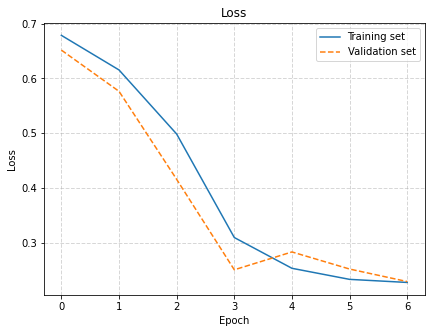

In [21]:
loss = H.history["loss"]
val_loss = H.history["val_loss"]
acc = H.history["accuracy"]
val_acc = H.history["val_accuracy"]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label="Training set")
plt.plot(val_loss, label="Validation set", linestyle="--")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(linestyle="--", linewidth=1, alpha=0.5)

#Plot Accuracy

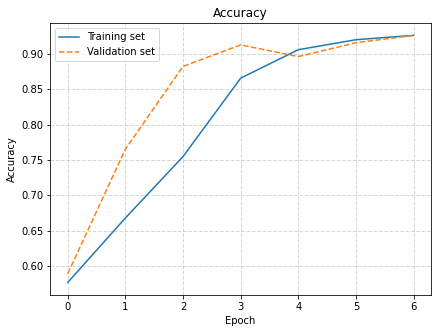

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.plot(acc, label="Training set")
plt.plot(val_acc, label="Validation set", linestyle="--")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(linestyle="--", linewidth=1, alpha=0.5)

##Menyimpan model dalam format SavedModel

In [24]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

##Convert SavedModel menjadi malaria.tflite

In [25]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('malaria_v1.tflite')
tflite_model_file.write_bytes(tflite_model)

14746492